In [ ]:
#importar librerias

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
from prophet import Prophet



c:\Users\Joabh\anaconda3\envs\proyectoDS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


c:\Users\Joabh\anaconda3\envs\proyectoDS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Joabh\anaconda3\envs\proyectoDS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\Joabh\anaconda3\envs\proyectoDS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


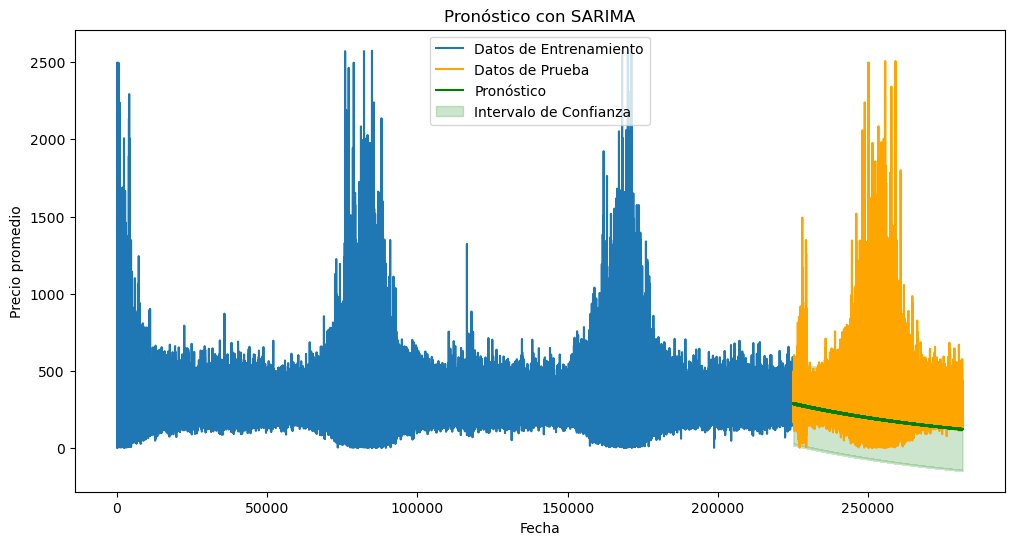

In [26]:

df_sample = pd.read_csv("C:/Users/Joabh/.cache/kagglehub/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/versions/8/2019-Nov.csv", usecols=['event_time', 'price'], nrows=5000000)

df_sample['event_time'] = pd.to_datetime(df_sample['event_time'])

df_sample['event_time'] = df_sample['event_time'].dt.tz_localize(None)

df_grouped = df_sample.groupby('event_time').mean().reset_index()

# Dividir el conjunto de datos en entrenamiento y prueba (80% entrenamiento y 20% prueba)
train_size = int(len(df_grouped) * 0.8)
train, test = df_grouped['price'][:train_size], df_grouped['price'][train_size:]

# Ajustar el modelo SARIMA en el conjunto de entrenamiento
sarima_model = SARIMAX(train, order=(2, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_results = sarima_model.fit()

# Realizar predicciones en el conjunto de prueba
forecast_test = sarima_results.get_forecast(steps=len(test))
forecast_test_df = forecast_test.conf_int()
forecast_test_df['forecast'] = forecast_test.predicted_mean

# Asegurarse de que los valores sean numéricos y rellenar cualquier NaN para evitar errores en la visualización
forecast_test_df['lower price'] = pd.to_numeric(forecast_test_df['lower price'], errors='coerce').interpolate()
forecast_test_df['upper price'] = pd.to_numeric(forecast_test_df['upper price'], errors='coerce').interpolate()
forecast_test_df['forecast'] = pd.to_numeric(forecast_test_df['forecast'], errors='coerce').interpolate()

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Graficar datos de entrenamiento
plt.plot(train.index, train, label='Datos de Entrenamiento')

# Graficar datos de prueba
plt.plot(test.index, test, label='Datos de Prueba', color='orange')

# Graficar pronóstico en el conjunto de prueba
plt.plot(test.index, forecast_test_df['forecast'], label='Pronóstico', color='green')

# Graficar intervalos de confianza
plt.fill_between(test.index, 
                 forecast_test_df['lower price'], 
                 forecast_test_df['upper price'], 
                 color='green', alpha=0.2, label='Intervalo de Confianza')

# Etiquetas y leyenda
plt.title('Pronóstico con SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Precio promedio')
plt.legend()
plt.show()  


Mean Absolute Error (MAE): 135.42722689563863
Mean Squared Error (MSE): 35619.36906260001
Root Mean Squared Error (RMSE): 188.73094357470904
MAE as Percentage: 44.34%
MSE as Percentage: 38.18%
RMSE as Percentage: 61.79%


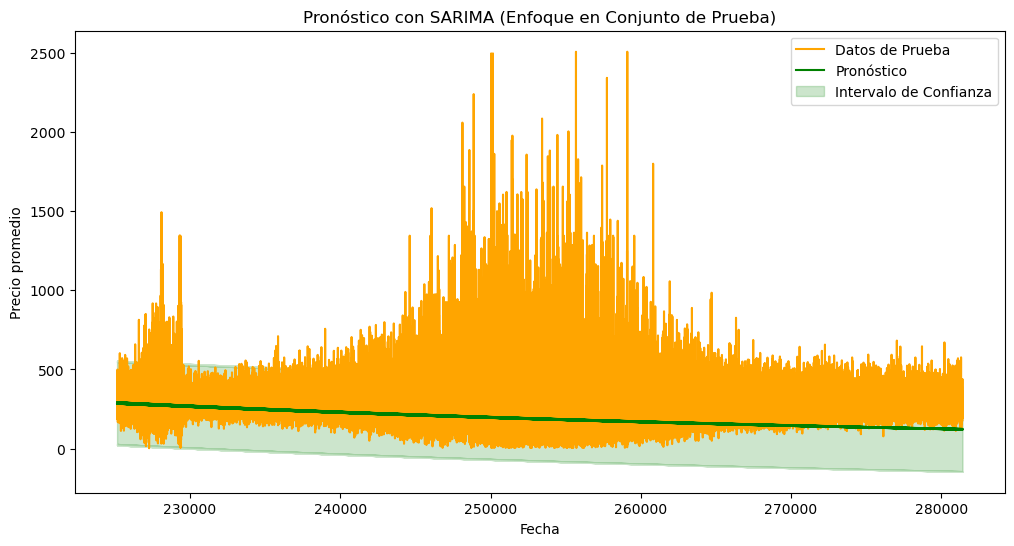

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Cálculo de métricas de error en el conjunto de prueba
y_true = test.values
y_pred = forecast_test_df['forecast'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

mean_y_true = np.mean(y_true)

mae_percentage = (mae / mean_y_true) * 100
mse_percentage = (mse / mean_y_true**2) * 100  # MSE relativo al cuadrado del valor medio
rmse_percentage = (rmse / mean_y_true) * 100

print(f"MAE as Percentage: {mae_percentage:.2f}%")
print(f"MSE as Percentage: {mse_percentage:.2f}%")
print(f"RMSE as Percentage: {rmse_percentage:.2f}%")

# Gráfica enfocada en la parte de test
plt.figure(figsize=(12, 6))

# Graficar el conjunto de prueba
plt.plot(test.index, test, label='Datos de Prueba', color='orange')

# Graficar el pronóstico en el conjunto de prueba
plt.plot(test.index, forecast_test_df['forecast'], label='Pronóstico', color='green')

# Graficar los intervalos de confianza
plt.fill_between(test.index, 
                 forecast_test_df['lower price'], 
                 forecast_test_df['upper price'], 
                 color='green', alpha=0.2, label='Intervalo de Confianza')

# Etiquetas y leyenda
plt.title('Pronóstico con SARIMA (Enfoque en Conjunto de Prueba)')
plt.xlabel('Fecha')
plt.ylabel('Precio promedio')
plt.legend()
plt.show()

In [ ]:
# buscar los mejores parametros
import itertools
import warnings
warnings.filterwarnings("ignore")

# Rango de valores para los parámetros
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # Asumiendo estacionalidad mensual

best_aic = float("inf")
best_params = None

# Búsqueda en todos los parámetros
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(df_grouped['price'], order=param, seasonal_order=seasonal_param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
            print(f"SARIMA{param}x{seasonal_param} - AIC:{results.aic}")
        except:
            continue

print(f"Mejores parámetros SARIMA: {best_params} con AIC: {best_aic}")

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:90602.73743759062
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:88903.75880704891
SARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:88060.86584276304
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:88504.34914292386
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:84344.08491730191
SARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:84345.96646761443
SARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:95109.09693397311
SARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:88417.11394783205
SARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:84368.164952473
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:87434.14342293853
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:84535.35743211885
SARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:84533.0379435168
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:86711.81061162453
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:84346.38213273643
SARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:84347.60153058276
SARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:91464.1146706857
SARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC:86636.86692993226
SARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC:84370.11909135878
SARIMA(0, 0, 0)x(2, 0, 0, 12) - 